## Importing required libraries

In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import cross_val_score

## Loading the dataset

In [2]:
data=pd.read_csv(r"data.csv")
data.head(10)

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,null;,2 -1,null;,null;,null;
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;
5,1178801459439296514,6ff6c6532fe0c399dcedd1dad6249c28,Mon Sep 30 22:39:03 +0000 2019,284,935,0,0,cnn:CNN:-0.9113024985533761;,3 -2,null;,null;,null;
6,1178802464914657286,dbd298dfc487b7e6a7e220439dc91983,Mon Sep 30 22:43:03 +0000 2019,3605,3526,5,13,null;,3 -1,null;,null;,null;
7,1178803230962327555,c3df67279d13e650c44d529c92476d30,Mon Sep 30 22:46:06 +0000 2019,5945,47,1,6,youtube:YouTube:-1.0295623705363122;super bowl...,3 -1,YouTube,null;,https://www.youtube.com/watch?v=jWdhOfNmLsE&fe...
8,1178803487037108225,fc48c9cc30420a1af599e735a14b0b8a,Mon Sep 30 22:47:07 +0000 2019,156538,3858,56,131,vontaze burfict:Vontaze_Burfict:-0.77486020920...,1 -1,null;,Raiders,null;
9,1178803977376415749,f734f2f2c94d7de900d18c59cc858d48,Mon Sep 30 22:49:03 +0000 2019,27014,24488,39,37,winter storm:Winter_storm:-1.9824755199970392;...,2 -1,AOC,null;,https://mtstandard.com/news/local/winter-storm...


## Pre-processing the data

In [3]:
#Extracting hour of tweet, which could be useful
data["Timestamp"]=pd.to_datetime(data.iloc[:,2]).apply(lambda x: x.hour)

In [4]:
#Splitting the sentiment into 2 columns: Positive_Sentiment and Negative_Sentiment
data["Positive_Sentiment"]=(data.Sentiment.str.split(" ").apply(lambda x: int(x[0])))
data["Negative_Sentiment"]=(data.Sentiment.str.split(" ").apply(lambda x: int(x[1])))
data.head()

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs,Positive_Sentiment,Negative_Sentiment
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,22,619,770,0,0,null;,2 -1,null;,null;,null;,2,-1
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,22,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...,1,-4
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,22,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:,2,-1
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,22,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;,2,-1
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,22,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;,2,-1


In [5]:
#Adding a feature consisting of the number of mentions
data["No_of_mentions"]=(data["Mentions"].apply(lambda x: str(x))).apply(lambda x: 0 if 'null;' in x else len(x.split()))
data.head()

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs,Positive_Sentiment,Negative_Sentiment,No_of_mentions
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,22,619,770,0,0,null;,2 -1,null;,null;,null;,2,-1,0
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,22,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...,1,-4,0
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,22,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:,2,-1,0
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,22,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;,2,-1,0
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,22,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;,2,-1,0


In [6]:
#Adding a feature consisting of the number of Hashtags
data["No_of_hashtags"]=(data["Hashtags"].apply(lambda x: str(x))).apply(lambda x: 0 if 'null;' in x else len(x.split()))
data.head()

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs,Positive_Sentiment,Negative_Sentiment,No_of_mentions,No_of_hashtags
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,22,619,770,0,0,null;,2 -1,null;,null;,null;,2,-1,0,0
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,22,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...,1,-4,0,0
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,22,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:,2,-1,0,0
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,22,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;,2,-1,0,0
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,22,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;,2,-1,0,1


In [7]:
#Dropping Tweet ID, Username, Sentiment
del data["Tweet ID"]
del data["Username"]
del data["Sentiment"]
del data["URLs"]
del data["Mentions"]
del data["Hashtags"]
del data["Entities"]

In [8]:
#Checking for duplicates
#Reference: https://machinelearningmastery.com/basic-data-cleaning-for-machine-learning/
dups = data.duplicated()
# list all duplicate rows
print(data[dups].shape[0],"duplicates were found.")

#Removing duplicates
if(data[dups].shape[0]!=0):
    data.drop_duplicates(inplace=True)
    print("Duplicates removed. Updated shape:",data.shape)

117 duplicates were found.
Duplicates removed. Updated shape: (99883, 9)


## Exploratory Data Analysis

#### Distribution of log(Followers), log(Friends), log(Favorites)

C:\Users\easha\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


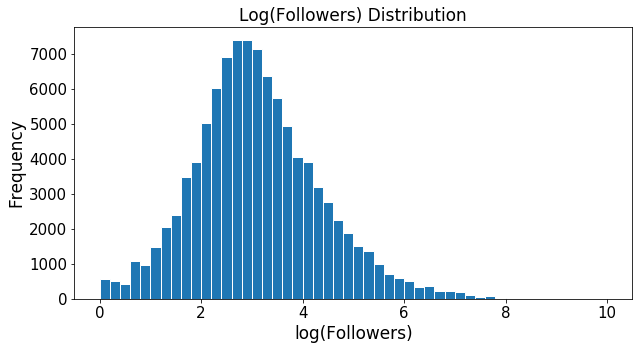

In [9]:
np.log10(data['#Followers']).plot.hist(bins=50, figsize=(10,5), edgecolor='white',range=[0,10])
plt.xlabel('log(Followers)', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Followers) Distribution', fontsize=17)
plt.show()

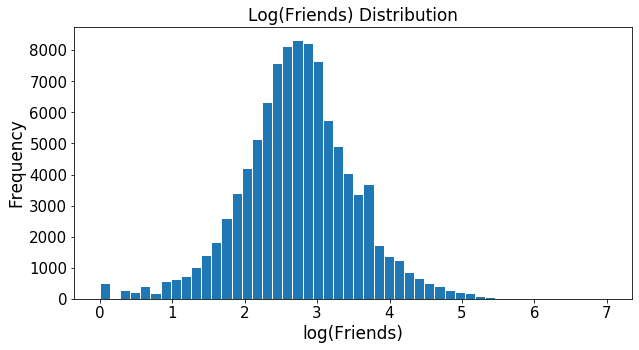

In [10]:
np.log10(data['#Friends']).plot.hist(bins=50, figsize=(10,5), edgecolor='white',range=[0,7])
plt.xlabel('log(Friends)', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Friends) Distribution', fontsize=17)
plt.show()

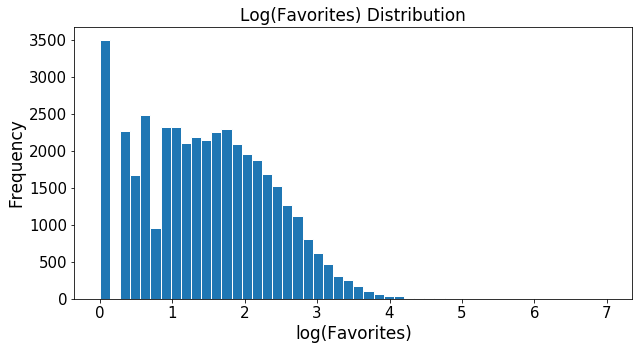

In [11]:
np.log10(data['#Favorites']).plot.hist(bins=50, figsize=(10,5), edgecolor='white',range=[0,7])
plt.xlabel('log(Favorites)', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Favorites) Distribution', fontsize=17)
plt.show()

#### Plotting correlation matrix

In [12]:
corr_columns=["#Followers","#Friends","#Favorites","Positive_Sentiment","Negative_Sentiment","#Retweets"]
data[corr_columns].corr()

,#Followers,#Friends,#Favorites,Positive_Sentiment,Negative_Sentiment,#Retweets
#Followers,1.000000,0.011319,0.172150,-0.027137,0.008767,0.134495
#Friends,0.011319,1.000000,0.017863,-0.000634,-0.007809,0.026489
#Favorites,0.172150,0.017863,1.000000,0.002486,-0.003841,0.890327
Positive_Sentiment,-0.027137,-0.000634,0.002486,1.000000,-0.039631,0.000386
Negative_Sentiment,0.008767,-0.007809,-0.003841,-0.039631,1.000000,-0.010521
#Retweets,0.134495,0.026489,0.890327,0.000386,-0.010521,1.000000


**From the correlation matrix, we can see that there is a high correlation between #Favorites and #Retweets. Whereas, all other predictors have little to no correlation with the #Retweets.**

2c. These correlation plots signify how related these variables are with each other and with the output variable i.e. #Retweets. 

2d. + signs in the matrix signify a positive correlation i.e. with increase in 1 value the other will also increase. - signs, signify negative correlation i.e. with increase in 1 value the other will decrease. 

2e. If a feature shows 0 correlation to #Retweets, that means that it doesn't contribute to the prediction, since it doesn't have any insights into #Retweets to offer. This hypothesis can be proven by ignoring all variables that have almost 0 correlation with the output variable #Retweets (everything except #Favorites) and running this file to the very end. We note that we get similar performances with using just #Favorites (See table attached with the submitted pdf). This proves that other variables that had a near 0 correlation with the #Retweets don't really add any value to the predictions. 

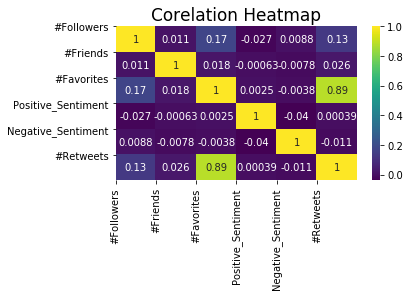

In [13]:
###### plt.figure(figsize=(9,6))
sns.heatmap(data[corr_columns].corr(), annot=True, cmap="viridis")
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.tight_layout()
plt.title("Corelation Heatmap", fontsize=17)
plt.show()

## Missing Data Imputation

In [14]:
#Checking for missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99883 entries, 0 to 99999
Data columns (total 9 columns):
Timestamp             99883 non-null int64
#Followers            99883 non-null int64
#Friends              99883 non-null int64
#Retweets             99883 non-null int64
#Favorites            99883 non-null int64
Positive_Sentiment    99883 non-null int64
Negative_Sentiment    99883 non-null int64
No_of_mentions        99883 non-null int64
No_of_hashtags        99883 non-null int64
dtypes: int64(9)
memory usage: 7.6 MB


From the infromation above, we note that there are only 2 columns that have null/missing data. These columns are: Mentions and Hashtags. 

Some strategies that could be used if missing data was found:
1. Filling in the mean in case of numerical columns (Drawback: Reduces the variance of a dataset)
2. Filling in most frequently occuring value (Useful when we have categorical columns)
3. K Nearest Neighbors (Drawback: It is computationally too expensive in case of high dimensional data)  
Reference: https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/#:~:text=Although%20any%20one%20among%20a,as%20%E2%80%9Cnearest%20neighbor%20imputation.%E2%80%9D
4. MICE (https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)

**In our case, we just have a total of 200 (approximately) rows that contain a column with null values. Since this number is really small, we can simply remove those rows with na values.**

In [15]:
data=data.dropna()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99883 entries, 0 to 99999
Data columns (total 9 columns):
Timestamp             99883 non-null int64
#Followers            99883 non-null int64
#Friends              99883 non-null int64
#Retweets             99883 non-null int64
#Favorites            99883 non-null int64
Positive_Sentiment    99883 non-null int64
Negative_Sentiment    99883 non-null int64
No_of_mentions        99883 non-null int64
No_of_hashtags        99883 non-null int64
dtypes: int64(9)
memory usage: 7.6 MB


## Normalization of numerical columns

In [17]:
X= data.drop("#Retweets", axis=1)
#X_Fav=pd.DataFrame(data["#Favorites"])
y= data["#Retweets"]

# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(X)
scaled=pd.DataFrame(scaled,columns=X.columns)
scaled.head()

,Timestamp,#Followers,#Friends,#Favorites,Positive_Sentiment,Negative_Sentiment,No_of_mentions,No_of_hashtags
0,0.956522,0.000008,0.000417,0.000000,0.25,1.00,0.0,0.000000
1,0.956522,0.000461,0.010469,0.000092,0.00,0.25,0.0,0.000000
2,0.956522,0.000064,0.001046,0.000000,0.25,1.00,0.0,0.000000
3,0.956522,0.000028,0.000526,0.000000,0.25,1.00,0.0,0.000000
4,0.956522,0.000114,0.002675,0.000479,0.25,1.00,0.0,0.033333


## Train Test Split

In [18]:
# split a dataset into train and test sets
from sklearn.model_selection import train_test_split
# split into train test sets
def train_test_split_method(X,y, testSize):
    X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=testSize)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train,X_test,y_train,y_test
X_train, X_test, y_train, y_test = train_test_split_method(scaled, y,0.20)

(79906, 8) (19977, 8) (79906,) (19977,)


## Model Training and Testing

### Base Model: The one that predicts the average

In [19]:
#Base model is the one that always returns mean
def baseModelPrediction(y_train):
    return y_train.mean()

mean=y_train.mean()


#calculate the mean, which will be the base model
base_model_results=pd.DataFrame({'Prediction':[mean for val in y_test],'Actual':y_test})

In [20]:
def model_building(X_train,y_train,model):
    return model.fit(X_train,y_train)

### Lasso Regression

In [21]:
#Building a lasso regression model:
clf=model_building(X_train,y_train,Lasso(alpha=0.1))
#Predicting using the lasso regression model:
lasso_results=pd.DataFrame({'Prediction':clf.predict(X_test),'Actual':y_test})

### K-nearest neighbors

In [22]:
#Building a k nearest neighbors regression model:
knn_reg=model_building(X_train,y_train,KNeighborsRegressor(n_neighbors=2))
#Predicting using the lasso regression model:
knn_results=pd.DataFrame({'Prediction':knn_reg.predict(X_test),'Actual':y_test})

### Random Forests

In [23]:
#Building a random forests regression model:
regr = model_building(X_train,y_train,RandomForestRegressor(max_depth=10))
#Predicting using the random forests regression model:
random_forest_results=pd.DataFrame({'Prediction':regr.predict(X_test),'Actual':y_test})

C:\Users\easha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Interpretation of Results

Some applicable evaluation metrics include: RMSE and R2. R2 indicates how much better that particular model does over the base model. RMSE indicates how far we are on average from the true values. 

In [24]:
def compute_RMSE(predicted, true):
    return (compute_variation(predicted,true).sum()/true.shape[0])**0.5

In [25]:
def compute_variation(predicted,true):
    return (predicted-true)**2

In [26]:
def computemetrics(metrics,model,X_test,y_test,mean_base_model):
    for val in model:
        r2=1-(compute_variation(val.predict(X_test),y_test).sum()/compute_variation([mean for val in y_test], y_test).sum())
        rmse=compute_RMSE(val.predict(X_test),y_test)
        model_name = type(val).__name__
        metrics=metrics.append({"Model":model_name,"R2":r2,"RMSE":rmse},ignore_index=True)
    return metrics

In [27]:
metrics=pd.DataFrame(columns=("Model","R2","RMSE"))
#call computemetrics function 
metrics_updated=computemetrics(metrics, [clf,knn_reg,regr],X_test,y_test,mean)

In [28]:
metrics_updated

,Model,R2,RMSE
0,Lasso,0.747568,137.834198
1,KNeighborsRegressor,0.406928,211.270445
2,RandomForestRegressor,0.647547,162.867819


#### Calculating CV Scores for each model

In [29]:
CV_df=pd.DataFrame(columns=['Model','CV Score (R2)'])
for val in [clf,knn_reg,regr]:
    score=cross_val_score(val,scaled,y,cv=10,scoring='r2')
    score=score.mean()
    CV_df=CV_df.append({"Model":type(val).__name__,'CV Score (R2)':score},ignore_index=True)

In [30]:
CV_df

,Model,CV Score (R2)
0,Lasso,0.669488
1,KNeighborsRegressor,0.455841
2,RandomForestRegressor,0.631774
